In [1]:
import numba
import os
import numpy as np
import zipfile
import shutil
import glob
import re
import math
import pandas as pd
from pathlib import Path
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline 
import pywt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Read Dataset

In [2]:
BASE_DIR = os.getcwd()
Dirs = {
    "BASE" : BASE_DIR,
    "DATASETS" : f"{BASE_DIR}{os.sep}datasets",
}

DatasetInfo = {
    "NAME" : "EGG",
    "ZIP_NAME" : "EGG-database",
    "ZIP_PATH" : r"C:\Users\Nada\Documents\Interns\GSOC\code\dataset\EGG-database.zip"
}

In [3]:
def build_dataset_directory(dataset_info):
    name, zip_path = dataset_info['NAME'], dataset_info["ZIP_PATH"]
    dataset_dir = f"{Dirs['DATASETS']}{os.sep}{name}"
    if(os.path.exists(dataset_dir)):
        shutil.rmtree(dataset_dir)
    Path(dataset_dir).mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    return dataset_dir
    
dataset_dir = build_dataset_directory(DatasetInfo)

In [4]:

def load_dataset_metadata(dataset_dir,i,label):
    record_name = f'ID{i}_{label}'
    record_path = f'{dataset_dir}{os.sep}{DatasetInfo["ZIP_NAME"]}{os.sep}ID{i}_{label}.txt'
    record = []
    record.append([record_name,record_path,label])
    return record


def build_dataframe():
    dataset_directory = dataset_dir
    records = []
    for i in range(1,21):
        records.extend(load_dataset_metadata(dataset_directory,i,'fasting'))
        records.extend(load_dataset_metadata(dataset_directory,i,'postprandial'))
    return  pd.DataFrame(records,columns=["name", "path", "label"])

df = build_dataframe()

In [5]:
df.head()

name                                               path  \
0       ID1_fasting  c:\Users\Nada\Documents\GitHub\numpy-analyzer\...   
1  ID1_postprandial  c:\Users\Nada\Documents\GitHub\numpy-analyzer\...   
2       ID2_fasting  c:\Users\Nada\Documents\GitHub\numpy-analyzer\...   
3  ID2_postprandial  c:\Users\Nada\Documents\GitHub\numpy-analyzer\...   
4       ID3_fasting  c:\Users\Nada\Documents\GitHub\numpy-analyzer\...   

          label  
0       fasting  
1  postprandial  
2       fasting  
3  postprandial  
4       fasting

In [6]:
df.to_csv(f"{DatasetInfo['NAME']}-metadata.csv")

In [7]:
def load_record(record,label):
    with open(record) as f:
        lines = f.readlines()
    record = []
    for index in range(len(lines)) :
        lines[index] = lines[index].split()
        for num in range(len(lines[index])):
            lines[index][num] = float(lines[index][num])
        # print(lines[index])
    record.append([lines,label])
    return record 

In [8]:
def load_records(df):
    data = []
    for i, j in df.iterrows():
        record  = load_record(j[1],j[2])
        data.extend(record)
    return data

records_data = load_records(df)



In [9]:
records_data[0]

[[[-0.193, -0.154, 0.137],
  [-0.335, -0.148, 0.212],
  [-0.124, 0.025, 0.235],
  [-0.084, 0.142, 0.286],
  [-0.073, 0.199, 0.305],
  [-0.081, -0.161, 0.331],
  [-0.178, 0.07, 0.562],
  [-0.149, -0.032, 0.39],
  [-0.135, 0.066, 0.418],
  [-0.146, 0.028, 0.389],
  [-0.149, 0.023, 0.367],
  [-0.21, -0.057, 0.348],
  [-0.25, -0.146, 0.28],
  [-0.191, -0.062, 0.389],
  [-0.187, -0.06, 0.507],
  [-0.146, -0.031, 0.571],
  [-0.138, 0.003, 0.485],
  [-0.194, -0.042, 0.471],
  [-0.153, -0.044, 0.529],
  [-0.197, -0.077, 0.636],
  [-0.239, -0.203, 0.533],
  [-0.227, -0.139, 0.412],
  [-0.304, -0.228, 0.426],
  [-0.34, -0.284, 0.388],
  [-0.379, -0.328, 0.426],
  [-0.367, -0.323, 0.105],
  [-0.295, -0.227, 0.225],
  [-0.257, -0.22, 0.246],
  [-0.176, -0.059, 0.332],
  [-0.163, -0.006, 0.293],
  [-0.219, -0.027, 0.297],
  [-0.256, -0.096, 0.312],
  [-0.226, -0.062, 0.313],
  [-0.158, 0.028, 0.252],
  [-0.201, -0.082, 0.18],
  [-0.184, -0.05, 0.198],
  [-0.197, -0.101, 0.274],
  [-0.218, -0.155, 0

### Analysis of dataset

In [10]:
print(f'Size of dataset = {len(records_data)}')
print(f'Length of each record = {len(records_data[0][0])}')

Size of dataset = 40
Length of each record = 2400


In [11]:
## get each ch readings separated
def separate_data_chs(record):
    ch1_readings = []
    ch2_readings = []
    ch3_readings = []
    ## loop over the record and get each ch reading
    for i in range(len(record)):
        ch1_readings.append(record[i][0])
        ch2_readings.append(record[i][1])
        ch3_readings.append(record[i][2])
    return ch1_readings,ch2_readings,ch3_readings
    
    

In [12]:
def plot_chs_readings(record,n=2400):
    record_label = record[1]
    ch1, ch2, ch3 = separate_data_chs(record[0])
    x = np.linspace(0,20,n)
    # Create figure with secondary y-axis
    fig = go.Figure()

    # Add traces
    fig.add_trace(
    go.Line(x=x, y=ch1, name="Ch1 readings")

    )

    fig.add_trace(
    go.Line(x=x, y=ch2, name="Ch2 readings")

    )

    fig.add_trace(
    go.Line(x=x, y=ch3, name="Ch3 readings")

    )

    # Add figure title
    fig.update_layout(
    title_text=f"<b>Channel readings for {record_label} sample</b>"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Time")


    fig.show()

In [13]:
def plot_random_samples(dataset,n_samples=5,seed=50):
    if n_samples > len(dataset):
        raise ValueError(f'Number of sample exceeds dataset size. Please enter a number less than or equal {len(dataset)}.')
    np.random.seed(seed)
    samples_index = np.random.randint(0, 20, size=n_samples)

    for index in samples_index:
        plot_chs_readings(dataset[index])


plot_random_samples(records_data)
    

c:\Users\Nada\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Wavelet transform

#### Steps:
- Denoising of Signal (using DWT)
- Try Synchrosqueezing of signal (ssqueezepy)
- Try wavelet scattering (Kymatio)


#### Synchrosqueezing WT


main function --> ssq_cwt
perfroms synchrosquezzing of CWT of a signal.

Source Code: https://github.com/OverLordGoldDragon/ssqueezepy/blob/master/ssqueezepy/_ssq_cwt.py


Arguments:


    x: np.ndarray
        Input vector(s), 1D or 2D.

Returns:


    Tx: np.ndarray [nf x n]
        Synchrosqueezed CWT of `x`. (rows=~frequencies, cols=timeshifts)
        (nf = len(ssq_freqs); n = len(x))
        `nf = na` by default, where `na = len(scales)`.

        
    Wx: np.ndarray [na x n]
        Continuous Wavelet Transform of `x`, L1-normed


    ssq_freqs: np.ndarray [nf]
        Frequencies associated with rows of `Tx`.


    scales: np.ndarray [na]
        Scales associated with rows of `Wx`.


    w: np.ndarray [na x n]  (if `get_w=True`)
        Phase transform for each element of `Wx`.


    dWx: [na x n] np.ndarray (if `get_dWx=True`)


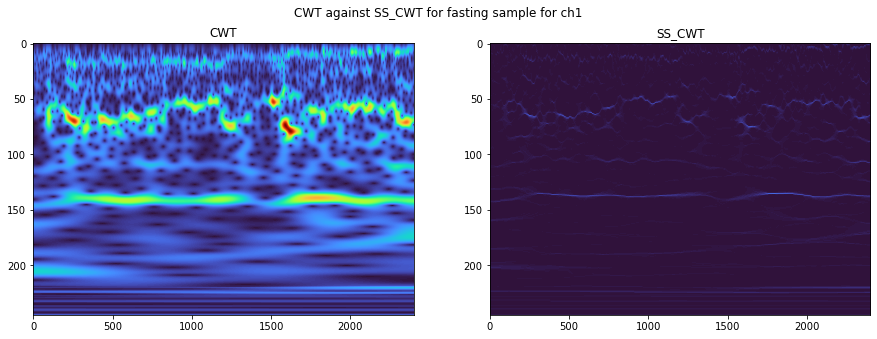

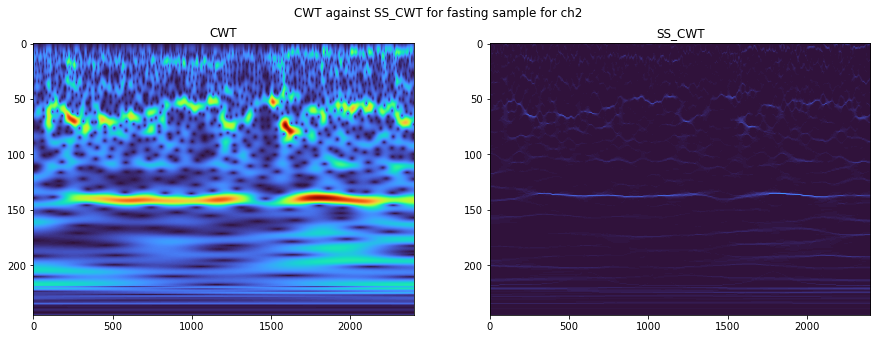

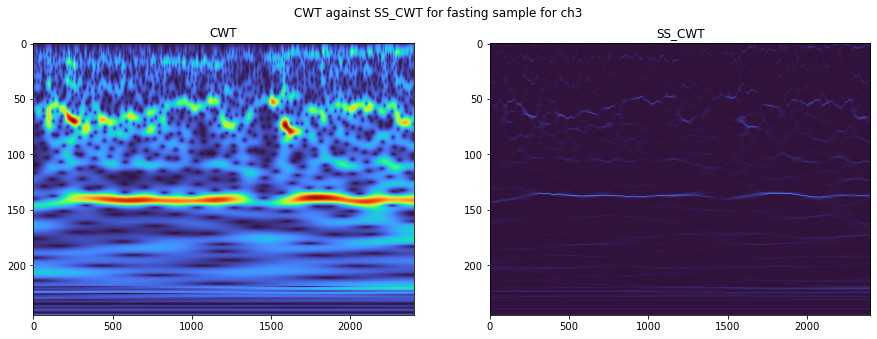

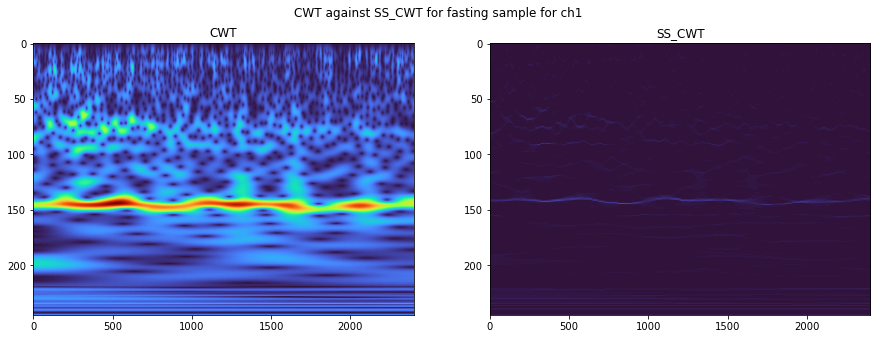

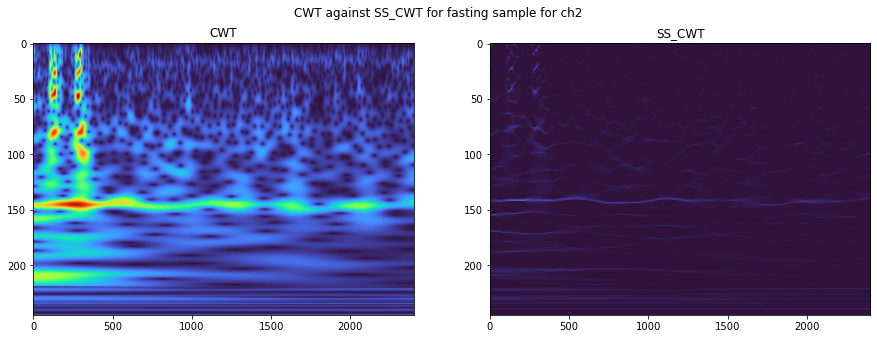

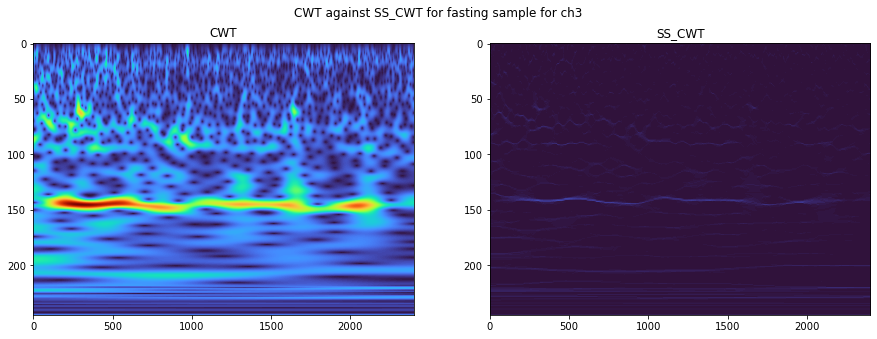

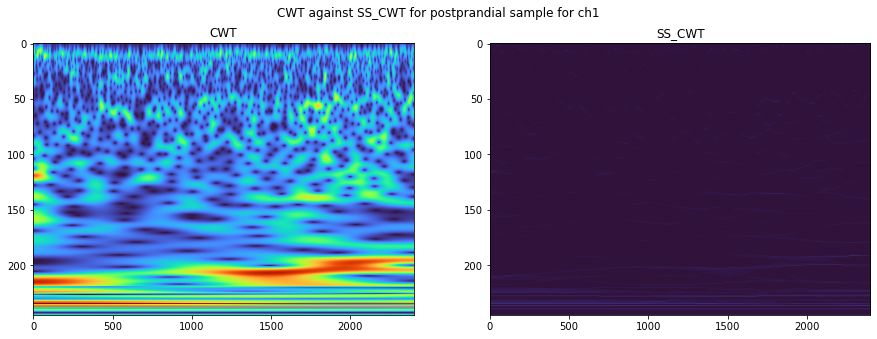

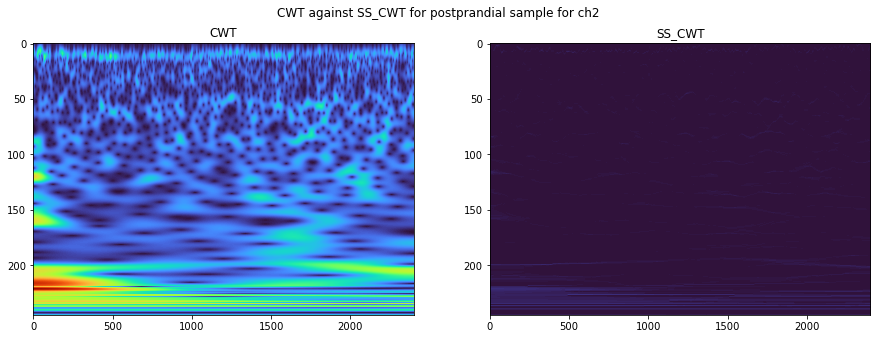

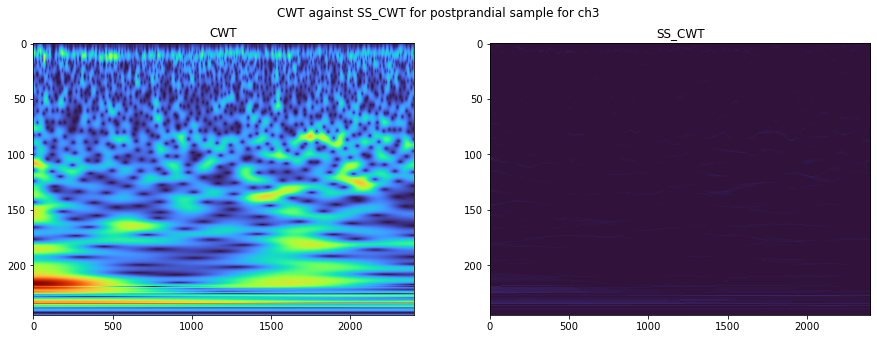

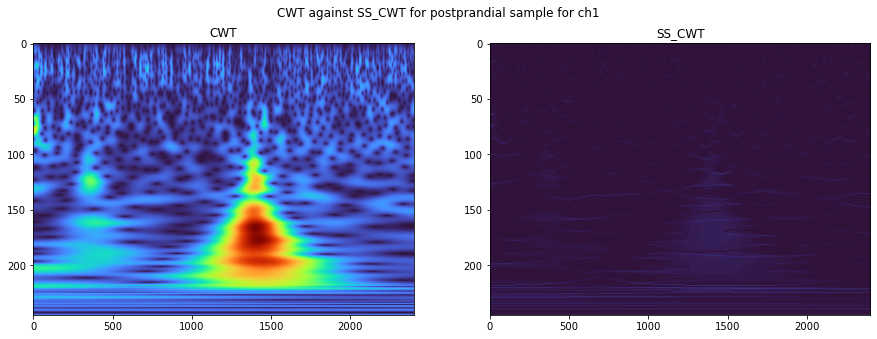

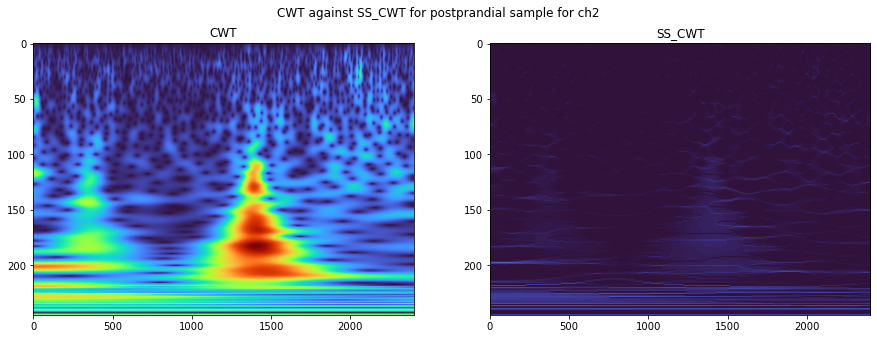

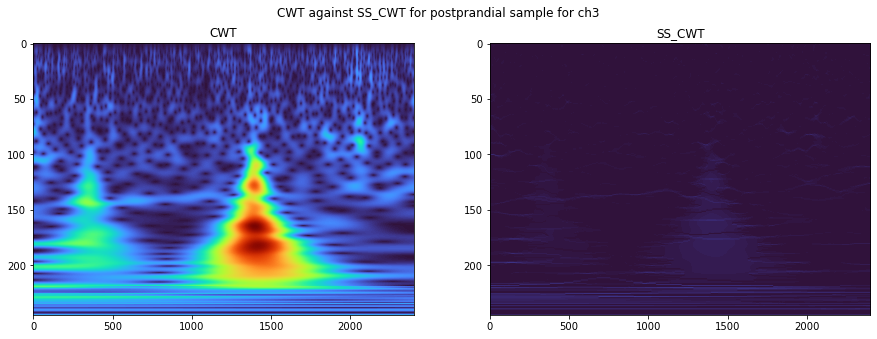

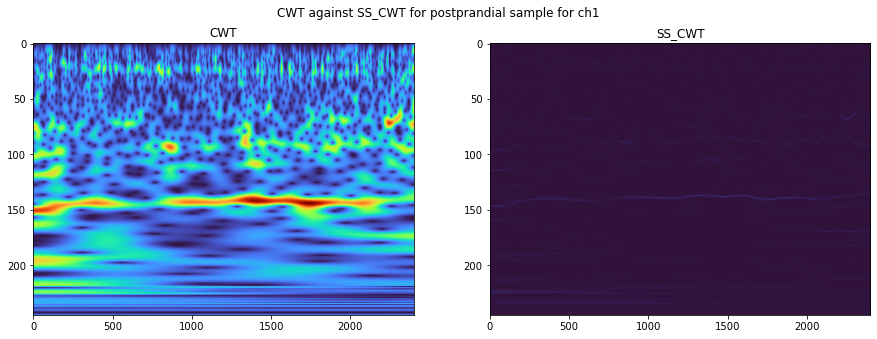

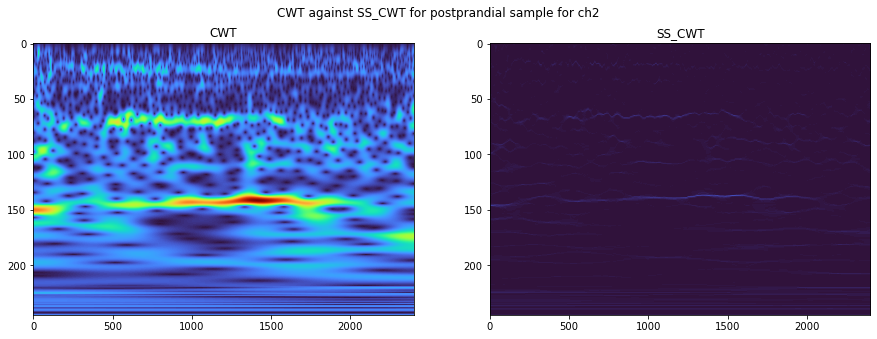

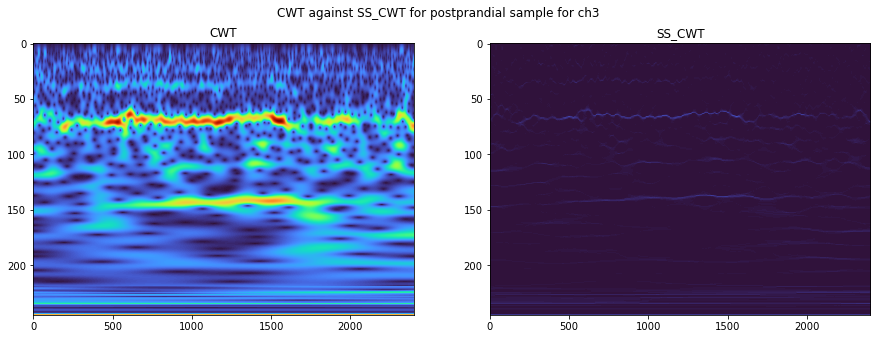

In [27]:
from ssqueezepy import ssq_cwt, ssq_stft


def visualize_WT(x, Tx, Wx,label,ch_num):
    fig = plt.figure(figsize=[15,5])
    fig.suptitle(f"CWT against SS_CWT for {label} sample for ch{ch_num}")
    plt.subplot(1, 2, 1)
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
    plt.title('CWT')
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(Tx), aspect='auto', vmin=0, vmax=.2, cmap='turbo')
    plt.title('SS_CWT')
    plt.show()


def ssqueeze(record):
    label = record[1]
    ch1, ch2, ch3 = separate_data_chs(record[0])
    SCWTch1, CWT1, *_ = ssq_cwt(np.array(ch1))
    visualize_WT(np.array(ch1), SCWTch1, CWT1,label,1)
    SCWTch2, CWT2, *_ = ssq_cwt(np.array(ch2))
    visualize_WT(np.array(ch2), SCWTch2, CWT2,label,2)
    SCWTch3, CWT3, *_ = ssq_cwt(np.array(ch3))
    visualize_WT(np.array(ch3), SCWTch3, CWT3,label,3)



def plot_random_samples(dataset,n_samples=5,seed=50):
    if n_samples > len(dataset):
        raise ValueError(f'Number of sample exceeds dataset size. Please enter a number less than or equal {len(dataset)}.')
    np.random.seed(seed)
    samples_index = np.random.randint(0, 20, size=n_samples)

    for index in samples_index:
        ssqueeze(dataset[index])

plot_random_samples(records_data)

#### Kymatio: Wavelet scattering in Python